In [2]:
import torch
import torch.optim as optim
from avalanche.benchmarks import SplitMNIST
from avalanche.models import SimpleMLP
from avalanche.training.supervised import EWC
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, forgetting_metrics
from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin
import matplotlib.pyplot as plt


In [4]:
# 1. Create the benchmark
benchmark = SplitMNIST(n_experiences=2, seed=1)

In [5]:
# 2. Create the model
model = SimpleMLP(num_classes=benchmark.n_classes)

In [6]:
# 3. Create the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [7]:
# 4. Create the EWC strategy
interactive_logger = InteractiveLogger()
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    loggers=[interactive_logger]
)

ewc = EWC(
    model, optimizer, criterion=torch.nn.CrossEntropyLoss(), ewc_lambda=0.4,
    train_mb_size=32, train_epochs=2, eval_mb_size=100, evaluator=eval_plugin
)

In [8]:
# 5. Training loop with evaluation
results = []

for experience in benchmark.train_stream:
    ewc.train(experience)
    results.append(ewc.eval(benchmark.test_stream))

-- >> Start of training phase << --
100%|██████████| 937/937 [00:12<00:00, 77.86it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1292
	Loss_MB/train_phase/train_stream/Task000 = 0.0047
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9602
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 937/937 [00:11<00:00, 78.99it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0504
	Loss_MB/train_phase/train_stream/Task000 = 0.0041
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9835
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 50/50 [00:01<00:00, 44.19it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0466
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9856
-- Starting eval on experience 1 (Task 0) from t

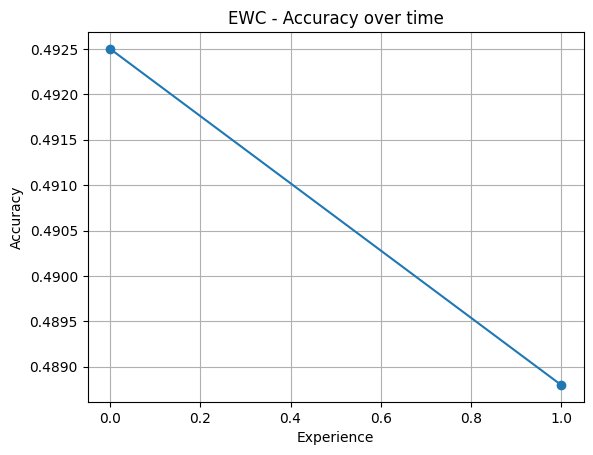

In [9]:
# 6. Plot the results
accuracies = [r['Top1_Acc_Stream/eval_phase/test_stream/Task000'] for r in results]

plt.figure()
plt.plot(accuracies, marker='o')
plt.title('EWC - Accuracy over time')
plt.xlabel('Experience')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
